In [1]:
import torch

from pulser_diff.pulser import Sequence, Pulse, Register
from pulser_diff.pulser.devices import MockDevice
from pulser_diff.pulser.waveforms import BlackmanWaveform, RampWaveform, CustomWaveform, ConstantWaveform
from pulser_diff.pulser.parametrized import Parametrized

from pulser_diff.model import QuantumModel
import matplotlib.pyplot as plt
from pulser_diff import TorchEmulator

### Toy optimization problem

In [2]:
# create register
reg = Register.rectangle(1, 2, spacing=8, prefix="q")

In [3]:
# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

In [4]:
# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)
area = torch.tensor([torch.pi], requires_grad=True)

In [5]:
# declare sequence variables
omega_param = seq.declare_variable("omega")
area_param = seq.declare_variable("area")

In [6]:
# create pulses
pulse_const = Pulse.ConstantPulse(1000, omega_param, 0.0, 0.0)
amp_wf = BlackmanWaveform(800, area_param)
det_wf = RampWaveform(800, 5.0, 0.0)
pulse_td = Pulse(amp_wf, det_wf, 0)

# add pulses
seq.add(pulse_const, "rydberg_global")
seq.add(pulse_td, "rydberg_global")

In [7]:
# create quantum model from sequence
trainable_params = {"omega": omega, "area": area}
model = QuantumModel(seq, trainable_params, sampling_rate=0.5, solver="krylov")

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


trainable_params.area
Parameter containing:
tensor([3.1416], requires_grad=True)
-------
trainable_params.omega
Parameter containing:
tensor([5.], requires_grad=True)
-------


In [8]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [9]:
# print initial expectation value as a result of simulating initial sequence
_, init_exp_val = model.expectation()
print("Initial expectation value:", init_exp_val[-1])
print()

# optimize model parameters so that the final output expectation value matches the predefined value
epochs = 20
target_value = torch.tensor(-0.5)
for t in range(epochs):
    # calculate prediction and loss
    evaluation_times, exp_val = model.expectation()
    loss = loss_fn(exp_val.real[-1], target_value)

    # backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # update sequence with changed pulse parameter values
    model.update_sequence()

    print(f"loss: {loss:>7f}")

# print expectation value with optimized model
_, init_exp_val = model.expectation()
print()
print("Optimized expectation value:", init_exp_val[-1])
print()

Initial expectation value: tensor(-1.2782+0.j, grad_fn=<SelectBackward0>)

loss: 0.605560
loss: 0.433920
loss: 0.252128
loss: 0.119507
loss: 0.050335
loss: 0.020542
loss: 0.008450
loss: 0.003535
loss: 0.001501
loss: 0.000645
loss: 0.000280
loss: 0.000122
loss: 0.000053
loss: 0.000023
loss: 0.000010
loss: 0.000005
loss: 0.000002
loss: 0.000001
loss: 0.000000
loss: 0.000000

Optimized expectation value: tensor(-0.5003+0.j, grad_fn=<SelectBackward0>)



We can print the optimized values of amplitude of the constant pulse `omega` and the area of the Blackman pulse `area`:

In [10]:
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


trainable_params.area
Parameter containing:
tensor([2.7814], requires_grad=True)
-------
trainable_params.omega
Parameter containing:
tensor([4.4623], requires_grad=True)
-------


The values of both parameters were optimized in order to minimize the provided loss function

### Custom waveform shape optimization

We will now show how to create a custom parametrized pulse shape and optimize the paramters governing such waveform.

In [11]:
# create register
reg = Register.rectangle(1, 2, spacing=8, prefix="q")

# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

In [12]:
duration = 1000

# define parameters governing the shape of custom amplitude waveform
param1_var = seq.declare_variable("param1")
param2_var = seq.declare_variable("param2")
param3_var = seq.declare_variable("param3")
param4_var = seq.declare_variable("param4")

def waveform(t: int, param1: Parametrized, param2: Parametrized, param3: Parametrized, param4: Parametrized) -> Parametrized:
    # custom waveform function
    var = param1 * (param4 * t/1000 - param3).cos() + param2
    return var

variables = {"param1": param1_var, "param2": param2_var, "param3": param3_var, "param4": param4_var}
for t in range(duration):
    # define variable for each time according to some function (waveform)
    var = waveform(t, param1_var, param2_var, param3_var, param4_var)
    pulse = Pulse.ConstantPulse(1, var, 0.0, 0.0)
    seq.add(pulse, "rydberg_global")

In [14]:
print(seq)

Prelude
-------
Channel: rydberg_global
t: 0 | Initial targets: q0, q1 | Phase Reference: 0.0 
t: 0->1 | Pulse(Amp=8.7 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 1->2 | Pulse(Amp=8.71 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 2->3 | Pulse(Amp=8.73 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 3->4 | Pulse(Amp=8.74 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 4->5 | Pulse(Amp=8.75 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 5->6 | Pulse(Amp=8.76 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 6->7 | Pulse(Amp=8.78 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 7->8 | Pulse(Amp=8.79 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 8->9 | Pulse(Amp=8.8 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 9->10 | Pulse(Amp=8.81 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 10->11 | Pulse(Amp=8.83 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0, q1
t: 11->12 | Pulse(Amp=8.84 rad/µs, 

In [16]:
# create quantum model from sequence
param1 = torch.tensor([5.0], requires_grad=True)
param2 = torch.tensor([6.0], requires_grad=True)
param3 = torch.tensor([1.0], requires_grad=True)
param4 = torch.tensor([3.0], requires_grad=True)
trainable_params = {"param1": param1, "param2": param2, "param3": param3, "param4": param4}
model = QuantumModel(seq, trainable_params, sampling_rate=0.5, solver="krylov")

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


trainable_params.param1
Parameter containing:
tensor([5.], requires_grad=True)
-------
trainable_params.param2
Parameter containing:
tensor([6.], requires_grad=True)
-------
trainable_params.param3
Parameter containing:
tensor([1.], requires_grad=True)
-------
trainable_params.param4
Parameter containing:
tensor([3.], requires_grad=True)
-------


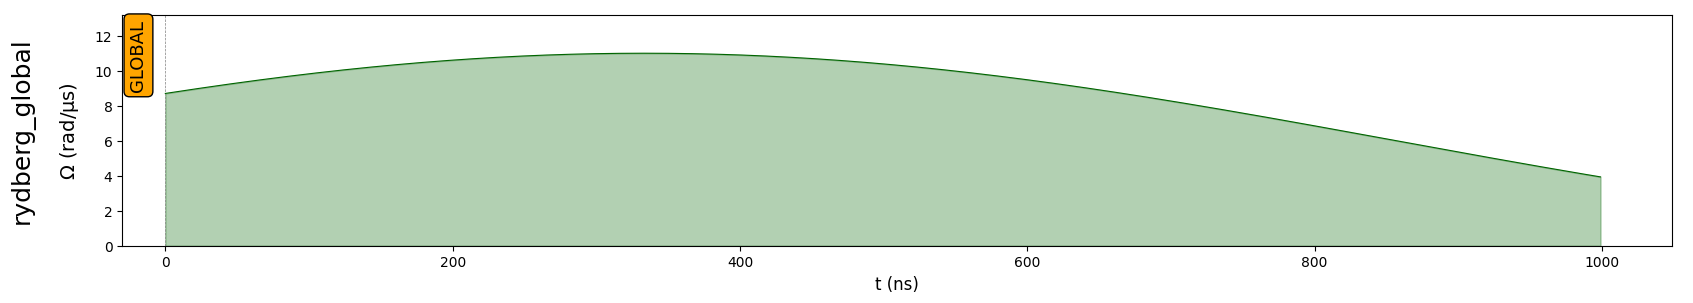

In [17]:
# draw sequence with INITIAL parameter values
model.built_seq.draw()

In [18]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)

In [19]:
# print initial expectation value as a result of simulating initial sequence
_, init_exp_val = model.expectation()
print("Initial expectation value:", init_exp_val[-1])
print()

# optimize model parameters so that the final output expectation value matches the predefined value
epochs = 20
target_value = torch.tensor(-0.5)
for t in range(epochs):
    # calculate prediction and loss
    evaluation_times, exp_val = model.expectation()
    loss = loss_fn(exp_val.real[-1], target_value)

    # backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # update sequence with changed pulse parameter values
    model.update_sequence()

    print(f"[t={t}] loss: {loss:>7f}")

    if loss < 0.0001:
        break

# print expectation value with optimized model
_, init_exp_val = model.expectation()
print()
print("Optimized expectation value:", init_exp_val[-1])
print()

Initial expectation value: tensor(-1.8903+0.j, grad_fn=<SelectBackward0>)

[t=0] loss: 1.932960
[t=1] loss: 0.880616
[t=2] loss: 0.068367
[t=3] loss: 0.000506
[t=4] loss: 0.000055

Optimized expectation value: tensor(-0.4973+0.j, grad_fn=<SelectBackward0>)



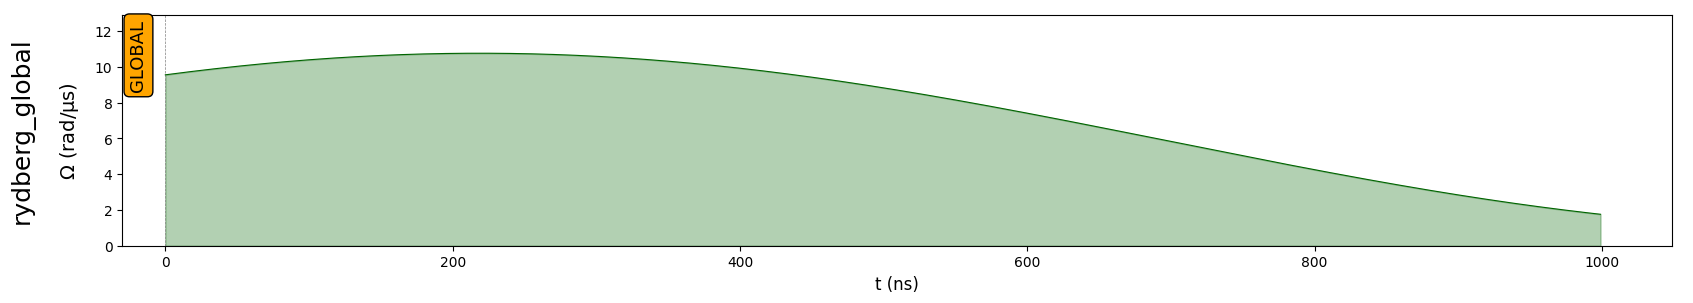

In [20]:
# draw sequence with OPTIMIZED parameter values
model.built_seq.draw()

In [21]:
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


trainable_params.param1
Parameter containing:
tensor([4.9184], requires_grad=True)
-------
trainable_params.param2
Parameter containing:
tensor([5.8501], requires_grad=True)
-------
trainable_params.param3
Parameter containing:
tensor([0.7163], requires_grad=True)
-------
trainable_params.param4
Parameter containing:
tensor([3.2724], requires_grad=True)
-------


As we can see the shape of the pulse changed smoothly to minimize the loss and approach the target value.